In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization,Cropping2D
from tensorflow.keras.models import Model
import random
import tensorflow as tf

In [2]:
# Đọc tệp Excel vào DataFrame
file_path = "/kaggle/input/btxrd-final/classification/classification.xlsx"  # Đường dẫn đến file Excel
df = pd.read_excel(file_path)

# Đường dẫn thư mục ảnh và mask
image_path = '/kaggle/input/btxrd-final/classification/images'
mask_path = '/kaggle/input/btxrd-final/classification/masks'
print("dfasdfd")

dfasdfd


In [3]:
# Lọc những ảnh có mask
df_with_mask = df[df['mask_flag'] == 1]

# Chia train, test, valid
df_train = df_with_mask[df_with_mask['tumor_category'] == 1].copy()
df_test  = df_with_mask[df_with_mask['tumor_category'] == 2].copy()
df_valid = df_with_mask[df_with_mask['tumor_category'] == 3].copy()
print("dfasdfd")

dfasdfd


In [4]:
# Tạo cột đường dẫn
df_train['image_path'] = df_train['image_id'].apply(lambda x: os.path.join(image_path, f"{os.path.splitext(x)[0]}.jpg"))
df_train['mask_path']  = df_train['image_id'].apply(lambda x: os.path.join(mask_path, f"{os.path.splitext(x)[0]}.png"))

df_test['image_path'] = df_test['image_id'].apply(lambda x: os.path.join(image_path, f"{os.path.splitext(x)[0]}.jpg"))
df_test['mask_path']  = df_test['image_id'].apply(lambda x: os.path.join(mask_path, f"{os.path.splitext(x)[0]}.png"))

df_valid['image_path'] = df_valid['image_id'].apply(lambda x: os.path.join(image_path, f"{os.path.splitext(x)[0]}.jpg"))
df_valid['mask_path']  = df_valid['image_id'].apply(lambda x: os.path.join(mask_path, f"{os.path.splitext(x)[0]}.png"))

print("dfasdfd")

dfasdfd


In [5]:
# Hàm load ảnh và mask
def load_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    
    image = tf.image.resize(image, (224, 224))
    mask = tf.image.resize(mask, (224, 224))
    return image, mask

# Chọn batch size random trước
BATCH_SIZE = random.choice([8, 16, 32, 64])

# Tạo datasets
train_dataset = tf.data.Dataset.from_tensor_slices((df_train['image_path'], df_train['mask_path']))
train_dataset = train_dataset.map(load_image_and_mask)
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((df_valid['image_path'], df_valid['mask_path']))
val_dataset = val_dataset.map(load_image_and_mask)
val_dataset = val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((df_test['image_path'], df_test['mask_path']))
test_dataset = test_dataset.map(load_image_and_mask)
test_dataset = test_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
print("dfasdfd")

dfasdfd


Train batch shape:
Image batch shape: (8, 224, 224, 1)
Mask batch shape: (8, 224, 224, 1)


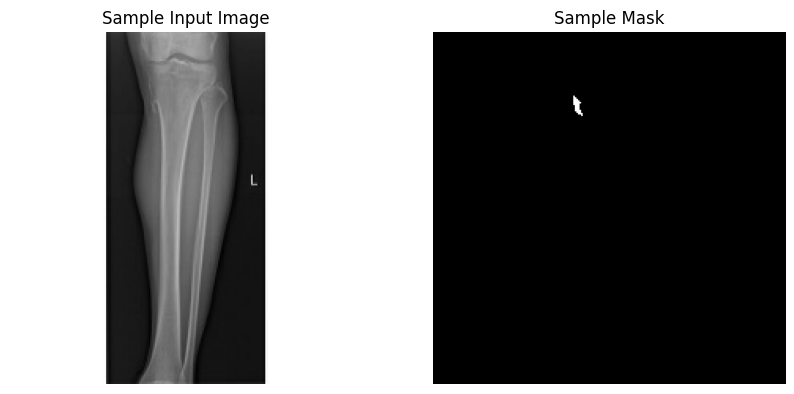

Validation batch shape:
Image batch shape: (16, 224, 224, 1)
Mask batch shape: (16, 224, 224, 1)


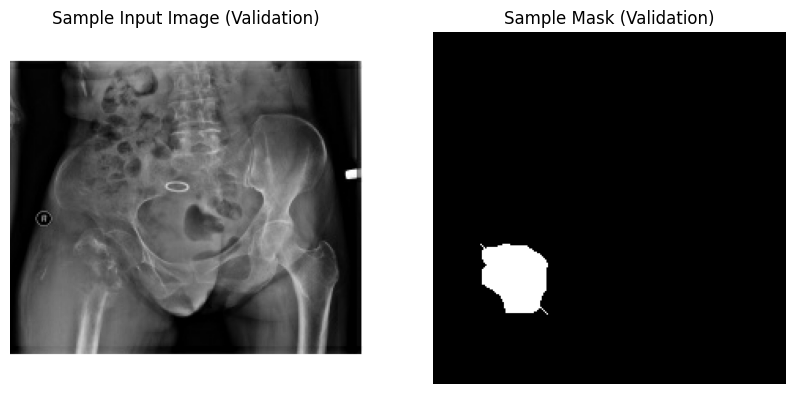

Test batch shape:
Image batch shape: (16, 224, 224, 1)
Mask batch shape: (16, 224, 224, 1)


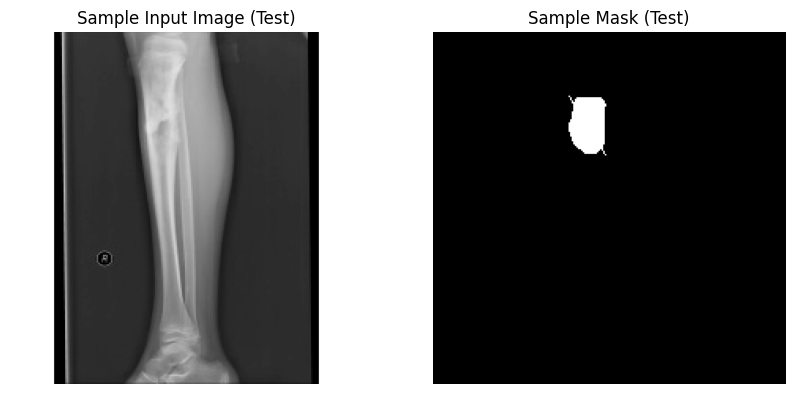

dfasdfd


In [6]:
import matplotlib.pyplot as plt

# Kiểm tra một batch từ train_dataset
for images, masks in train_dataset.take(1):  # Lấy 1 batch từ train_dataset
    print("Train batch shape:")
    print("Image batch shape:", images.shape)  # Kích thước của batch ảnh
    print("Mask batch shape:", masks.shape)    # Kích thước của batch mask

    # Hiển thị một ảnh và mask
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[0, :, :, 0], cmap='gray')  # Hiển thị ảnh đầu tiên trong batch (1 channel)
    plt.title("Sample Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0, :, :, 0], cmap='gray')  # Hiển thị mask đầu tiên trong batch (1 channel)
    plt.title("Sample Mask")
    plt.axis('off')

    plt.show()
    break  # Dừng sau khi đã kiểm tra 1 batch

# Kiểm tra một batch từ val_dataset
for images, masks in val_dataset.take(1):
    print("Validation batch shape:")
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[0, :, :, 0], cmap='gray')
    plt.title("Sample Input Image (Validation)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0, :, :, 0], cmap='gray')
    plt.title("Sample Mask (Validation)")
    plt.axis('off')

    plt.show()
    break

# Kiểm tra một batch từ test_dataset
for images, masks in test_dataset.take(1):
    print("Test batch shape:")
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[0, :, :, 0], cmap='gray')
    plt.title("Sample Input Image (Test)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0, :, :, 0], cmap='gray')
    plt.title("Sample Mask (Test)")
    plt.axis('off')

    plt.show()
    break
print("dfasdfd")

In [7]:
from PIL import Image

# Mở ảnh
image = Image.open('/kaggle/input/btxrd-final/classification/masks/IMG000001.png')

# Lấy kích thước ảnh (width, height)
width, height = image.size
print(f"Width: {width}, Height: {height}")

Width: 224, Height: 224


In [8]:
def unet_model(input_shape=(224, 224, 1), num_classes=1, num_levels=4, initial_filters=64):
    """
    Tạo mô hình U-Net với số cấp độ (num_levels) và số lượng filters ban đầu (initial_filters).
    """
    def conv_block(x, filters):
        """Tạo một block convolution gồm 2 lớp Conv2D với kích thước kernel (3, 3) và activation 'relu'."""
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        return x

    def encoder_block(x, filters):
        """Tạo một block Encoder gồm Conv2D và MaxPooling2D."""
        x = conv_block(x, filters)
        pool = layers.MaxPooling2D((2, 2))(x)  # MaxPooling giảm kích thước ảnh
        return x, pool

    def decoder_block(x, skip, filters):
        """Tạo một block Decoder gồm UpSampling và kết hợp với skip connection."""
        up = layers.UpSampling2D((2, 2))(x)  # Upsample để khôi phục kích thước
        merge = layers.concatenate([up, skip])  # Kết hợp với skip connection từ Encoder
        x = conv_block(merge, filters)  # Thực hiện convolution sau khi kết hợp
        return x

    # Input layer
    inputs = layers.Input(shape=input_shape)
    skips = []  # List lưu các skip connection (kết nối từ các tầng encoder)
    x = inputs
    filters = initial_filters

    # Encoder: Các lớp Conv2D và MaxPooling2D
    for _ in range(num_levels):
        conv, pool = encoder_block(x, filters)
        skips.append(conv)  # Lưu lại các skip connection
        x = pool
        filters *= 2  # Tăng số lượng filters sau mỗi cấp độ

    # Bottleneck: Block giữa encoder và decoder
    x = conv_block(x, filters)

    # Decoder: Các lớp Upsample và Conv2D với skip connection
    filters //= 2  # Giảm số lượng filters
    for skip in reversed(skips):
        x = decoder_block(x, skip, filters)
        filters //= 2  # Giảm số lượng filters

    # Output layer: Lớp cuối với kích thước 1x1 để tạo ra số lớp phân loại
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(x)

    # Tạo mô hình
    model = models.Model(inputs, outputs)
    
    return model

# Tạo mô hình U-Net với 4 cấp độ và số lượng filters ban đầu là 32
model = unet_model(num_levels=4, initial_filters=32)
model.summary()

# Bạn có thể tạo mô hình với số cấp độ khác nhau
# model_5_levels = unet_model(num_levels=5, initial_filters=16)
# model_5_levels.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 14, 14, 256)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 14, 14, 512)    │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 14, 14, 512)    │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 28, 28, 512)    │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 28, 28, 768)    │              0 │ up_sampling2d[0][0],   │
│                      

 Total params: 7,846,081 (29.93 MB)

 Trainable params: 7,846,081 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Định nghĩa mô hình
model = unet_model()

# Compile mô hình với metrics phù hợp hơn
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])  # Giả sử 2 lớp (nền và đối tượng)

# Định nghĩa callbacks
checkpoint_filepath = 'unet_best_model.keras'  # Đổi tên thành .keras
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_mean_io_u',  # Theo dõi IoU trên tập validation
    mode='max')

early_stopping_callback = EarlyStopping(
    monitor='val_mean_io_u',  # Theo dõi IoU trên tập validation
    patience=10,
    mode='max',
    restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_mean_io_u',  # Theo dõi IoU trên tập validation
    factor=0.1,
    patience=5,
    min_lr=0.00001)

callbacks = [model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]

# Huấn luyện mô hình với callbacks
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 175s 789ms/step - accuracy: 0.9786 - loss: 0.7259 - mean_io_u: 0.4813 - val_accuracy: 0.9824 - val_loss: 0.0758 - val_mean_io_u: 0.4912 - learning_rate: 0.0010
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 69s 417ms/step - accuracy: 0.9830 - loss: 0.0855 - mean_io_u: 0.4821 - val_accuracy: 0.9824 - val_loss: 0.0753 - val_mean_io_u: 0.4912 - learning_rate: 0.0010
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 69s 416ms/step - accuracy: 0.9823 - loss: 0.0753 - mean_io_u: 0.4817 - val_accuracy: 0.9824 - val_loss: 0.0713 - val_mean_io_u: 0.4912 - learning_rate: 0.0010
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 69s 415ms/step - accuracy: 0.9821 - loss: 0.0770 - mean_io_u: 0.4817 - val_accuracy: 0.9824 - val_loss: 0.0780 - val_mean_io_u: 0.4912 - learning_rate: 0.0010
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 69s 413ms/step - accuracy: 0.9827 - loss: 0.0742 - mean_io_u: 0.4818 - val_accuracy: 0.9824 - val_loss: 0.0701 - val_mean_io_u: 0.4912 - learning_rate: 0.0010
Epoc

In [10]:
results = model.evaluate(test_dataset)
print(f"Results: {results}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 877ms/step - accuracy: 0.9817 - loss: 0.0784 - mean_io_u: 0.4908
Results: [0.07570859789848328, 0.9825575351715088, 0.49040666222572327]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step


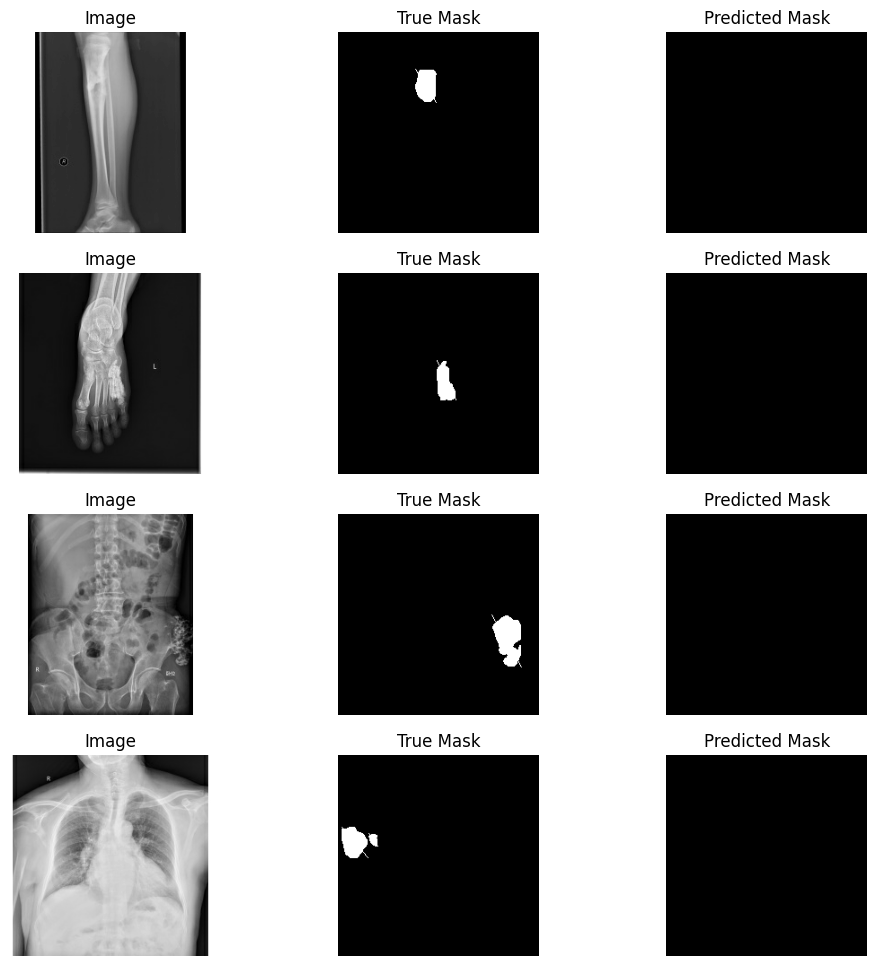

In [11]:
# Dự đoán trên test dataset và hiển thị kết quả
for image_batch, mask_batch in test_dataset.take(1):  # Chỉ lấy một batch từ test dataset
    pred_batch = model.predict(image_batch)  # Dự đoán cho batch
    pred_batch = (pred_batch > 0.5).astype(np.float32)  # Chuyển sang nhị phân (0 hoặc 1)

    # Hiển thị ảnh gốc, mask thực tế và mask dự đoán
    plt.figure(figsize=(12, 12))
    for i in range(min(4, len(image_batch))):  # Chỉ hiển thị 4 ảnh đầu tiên
        # Ảnh gốc
        plt.subplot(4, 3, i * 3 + 1)
        plt.imshow(image_batch[i, :, :, 0], cmap='gray')
        plt.title("Image")
        plt.axis('off')

        # Mask thực tế
        plt.subplot(4, 3, i * 3 + 2)
        plt.imshow(mask_batch[i, :, :, 0], cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        # Mask dự đoán
        plt.subplot(4, 3, i * 3 + 3)
        plt.imshow(pred_batch[i, :, :, 0], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.show()


In [12]:
model.save('unet_model.h5')  # Lưu mô hình dưới dạng file .h5
model.save('/kaggle/working/unet_model.h5')  # Lưu mô hình vào thư mục /kaggle/working

In [13]:
from IPython.display import FileLink

# Tạo liên kết tải xuống cho file mô hình
FileLink('/kaggle/working/unet_model.h5')

/kaggle/working/unet_model.h5